In [1]:
# for table 1
import os
import matplotlib.pyplot as plt
import datetime
import time
import json
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress

from helpers.expr_query import ExprDataQuery
from helpers.scale_data import ScaleData
from helpers.similarity import Similarity
from helpers.feature_selection import FeatureSelection

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error as rmse_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
import random
np.random.seed(42)
random.seed(47906)

In [3]:
fs_method = 'RFE' #'Variance' #
est_name = 'DecisionTree'

In [4]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Data preparation

In [5]:
ALL_CPUS = [2, 4, 8, 16]
ALL_PAIRS = [(0, 1), (0, 2), (0,3), (1, 2), (1, 3), (2, 3)]
K_RANGE = [3]
PAIR = (2, 3)
if PAIR is None:
    candid_idx = 0
else:
    candid_idx = PAIR[0]
temp_candid_idx = 0

In [6]:
data = ExprDataQuery()
data.load_pickle()
data = data.remove_empty_plan()

In [7]:
all_queries = [g for g, n in zip(data.wl_groups, data.wl_names) if 'ycsb-' in n or 'twitter-' in n]
all_groups = [g for g, n in zip(data.wl_groups, data.wl_names) if 'ycsb' in n]
all_groups = np.unique(all_groups)

In [8]:
# candidate_query_groups =  [f'{num}' for num in list(range(28, 89))] 
# candidate_query_groups =  [f'{num}' for num in list(range(56, 62))] 
candidate_query_groups =  [f'{num}' for num in list(range(56, 62))] 
candidate_wl_group = '25' # TODO: candidate workload select 
all_candid_groups = [candidate_wl_group] + candidate_query_groups # this is the set of all wl and query groups for prediction

In [9]:
remove_g = [g for g in all_queries if g not in candidate_query_groups]
print(remove_g)
data_all = data.remove_by_group(remove_g)

['19', '19', '19', '19', '3', '3', '3', '3', '9', '9', '9', '9', '11', '11', '11', '11', '21', '21', '21', '21', '5', '5', '5', '5', '10', '10', '10', '10', '20', '20', '20', '20', '4', '4', '4', '4', '12', '12', '12', '12', '22', '22', '22', '22', '6', '6', '6', '6', '13', '13', '13', '13', '23', '23', '23', '23', '7', '7', '7', '7', '32', '32', '32', '32', '88', '88', '88', '88', '29', '29', '29', '29', '85', '85', '85', '85', '33', '33', '33', '33', '89', '89', '89', '89', '28', '28', '28', '28', '84', '84', '84', '84', '30', '30', '30', '30', '86', '86', '86', '86', '31', '31', '31', '31', '87', '87', '87', '87']


In [10]:
chwl_data = data_all.remove_by_wlname([ 'tpcc', 'tpch', 'xml', 'twitter']) 
chwl_data = chwl_data.remove_by_group([g for g in all_groups if g != candidate_wl_group])
print(chwl_data.wl_groups)

['25', '25', '25', '25']


In [11]:
osq_datas = []
for candidate_query_group in candidate_query_groups:
    osq_data = data_all.remove_by_wlname([ 'tpcc', 'tpch', 'xml', 'twitter']) # remove known data
    osq_data = osq_data.remove_by_group([g for g in all_groups if g != candidate_query_group])
    osq_data = osq_data.sample_data()
    if len(osq_data.wl_names) == 0:
        continue
    idx, = np.where(np.array(osq_data.wl_groups) == candidate_query_group)
    osq_datas.append({'data': osq_data, 'name': osq_data.wl_names[0], 'wl_group': candidate_query_group})

# keep tpch as it is as it provides some other behavior pattern when using different cpu number (const)
known_data = data_all.remove_by_wlname(['xml'])
known_data = known_data.remove_by_group(all_candid_groups + remove_g)

In [12]:
for osq_data in osq_datas:
    print(osq_data['name'])

ycsb-ReadRecord
ycsb-InsertRecord
ycsb-ScanRecord
ycsb-UpdateRecord
ycsb-DeleteRecord
ycsb-ReadModifyWriteRecord


In [13]:
sampled_data = known_data.sample_data()
data_by_type = sampled_data.split_by_type()

In [14]:
# osq_data = osq_data.sample_data()
# X_label = 'SKU'
X_label = 'cpu_num'
y_label = 'latency'

expr_label = 'EXPR'
y_true_label = 'Y_TRUE'
y_pred_label = 'Y_PRED'
suffix_labels = ['_small', '_large']

In [15]:
def get_cpu_nums_as_X(l):
    return np.array([int(e[3:]) for e in l]).reshape(-1, 1)

In [16]:
for i in range(len(osq_datas)):
    osq_data = osq_datas[i]['data']
    osq_X = get_cpu_nums_as_X(osq_data.cpu_nums)
    osq_y = np.array(osq_data.wl_latency)
    osq_expr = np.array(osq_data.sampled_run_idx)
    osq_datas[i]['x'] = osq_X
    osq_datas[i]['y'] = osq_y
    osq_datas[i]['expr'] = osq_expr

In [17]:
chwl_data = chwl_data.sample_data()
chwl_X = get_cpu_nums_as_X(chwl_data.cpu_nums)
chwl_y = np.array(chwl_data.wl_latency)
chwl_expr = np.array(chwl_data.sampled_run_idx)

### Feature selection

In [18]:
# Feature selection using ONLYknow data
scaler = ScaleData()
plan_mtxs, plan_col_ranges = scaler.scale(known_data.plan_mtxs, scale=False)

ksimi_calc = Similarity(known_data, plan_mtxs, plan_col_ranges,[], [], num_bins=100)
ksimi_calc.calc_bined_mtx(plan_only=True) # all features

In [19]:
fs = FeatureSelection(ksimi_calc)

In [20]:
top_7 = fs.select_features(7, fs_method, est_name=est_name, direction='backward', feature_type='plan')
print(top_7)

(44, 44, 22)
['TableCardinality', 'EstimatedRowsRead', 'EstimateRows', 'EstimateRewinds', 'EstimateRebinds', 'EstimateIO', 'AvgRowSize']


# Same model different scope

In [21]:
def get_simis(simi_data, simi_mtx, candid_group):
    
    groups = list(np.unique(simi_data.wl_groups))
    vals = [0]*len(groups)
    counts = [0]*len(groups)
    for i in range(len(simi_mtx)):
        if simi_data.wl_groups[i] != candid_group:
            continue
        # print(simi_mtx[i])
        for j, val in enumerate(simi_mtx[i]):
            curr_g = simi_data.wl_groups[j]
            if curr_g != candid_group:
                vals[groups.index(curr_g)] += val
                counts[groups.index(curr_g)] += 1
            else:
                vals[groups.index(curr_g)] = float('inf')
                counts[groups.index(curr_g)] = 1
    mean_dists = [v / c for (v, c) in zip(vals, counts)]

    df = pd.DataFrame({'dist': mean_dists, 'wl_groups': groups} )

    df.sort_values(by=['dist'], ascending=True, inplace=True)
    # print(df)
    return df['wl_groups'].to_list()

### Build models for existing workloads

In [22]:
def nrmse_score(y_true, y_pred):
    return rmse_score(y_true, y_pred)/(1+np.max(y_true)-np.min(y_true))

score_func = make_scorer(nrmse_score, greater_is_better=False)

In [23]:
'''
Use a dictionary of models
- key: (lower SKU, higher SKU)
- value: model
'''
def trend_predict(model_dicts, X, y_true, expr_idxs, method, k, sku_pair=None, show_fig=True):
    overall_data = pd.DataFrame(zip(X, expr_idxs, y_true), columns=[X_label, expr_label, y_true_label])
    # for each pair of SKU
    num_cpus = np.sort(np.unique(X))
    test_scores = []
    models, datas_big, datas_small = [], [], []
    dfs = []
        
    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            if sku_pair is not None and (i != sku_pair[0] or j != sku_pair[1]):
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            
            curr_smaller = overall_data[overall_data[X_label] == cpu_a]
            curr_bigger = overall_data[overall_data[X_label] == cpu_b]
            
            new_preds = []
            
            for model_dict in model_dicts:            
                new_y_true, new_y_pred = [], []

                curr_smaller_pred = model_dict[(cpu_a, cpu_b)].predict(curr_smaller[X_label].to_numpy().reshape(-1, 1))
                curr_bigger_pred = model_dict[(cpu_a, cpu_b)].predict(curr_bigger[X_label].to_numpy().reshape(-1, 1))
                curr_smaller = curr_smaller.assign(Y_PRED=curr_smaller_pred)
                curr_bigger = curr_bigger.assign(Y_PRED=curr_bigger_pred)

                for _, smaller_row in curr_smaller.iterrows():
                    curr_expr_idx = smaller_row[expr_label]
                    curr_diff = smaller_row[y_true_label] - smaller_row[y_pred_label]
                    bigger_row = curr_bigger[curr_bigger[expr_label] == curr_expr_idx]
                    assert(bigger_row.shape[0] == 1)
                    bigger_row = bigger_row.iloc[0]
                    new_y_true.append(bigger_row[y_true_label])
                    new_y_pred.append(bigger_row[y_pred_label] + curr_diff)
                new_preds.append(new_y_pred)

            curr_bigger = curr_bigger.assign(Y_PRED=np.mean(np.array(new_preds), axis=0))
            df = pd.merge(curr_smaller, curr_bigger, on=[expr_label], suffixes=suffix_labels)
            dfs.append(df)
            
            if len(new_y_true) == 1:
                print("only 1")
                score = rmse_score(new_y_true, new_y_pred)/new_y_true[0]
            else:
                score = rmse_score(new_y_true, new_y_pred)/(1+np.max(new_y_true) - np.min(new_y_true))
            test_scores.append(score)
                
            models.append(model_dict[(cpu_a, cpu_b)])
            datas_small.append(curr_smaller)
            datas_big.append(curr_bigger)

    overall_score = np.mean(test_scores)
    return overall_score, dfs

In [24]:
def build_regression_model(X, y, wl_name, grouping_type, groupping_id, plot=False, show_fig=False):  
    train_rmses, test_rmses = [], []
    k = 5
    num_cpus = np.sort(np.unique(X))
    train_time = 0
    model_dict = {}
    models = []
    fold_test_rmses = []
    
    kf = KFold(n_splits=k, shuffle=True)
    for train_index, test_index in kf.split(X):
        start = time.time()

        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        test_pred = reg.predict(X_test)
        train_pred = reg.predict(X_train)
        end = time.time()
        train_time += end - start
        
        num_pairs = 0
        for i in range(len(num_cpus)):
            for j in range(i, len(num_cpus)):
                if i == j:
                    continue
                cpu_a = num_cpus[i] # smaller
                cpu_b = num_cpus[j] # larger
                curr_mask = [x_lab == cpu_a or x_lab == cpu_b for x_lab in X_test.flatten()]

                curr_y_true = y_test[curr_mask]
                # rmse = np.sqrt(((curr_y_true-test_pred[curr_mask])**2).mean())
                rmse = rmse_score(curr_y_true, test_pred[curr_mask])
                if len(curr_y_true) == 1:
                    n_rmse = rmse/curr_y_true[0]
                else:
                    n_rmse = rmse / (1+np.max(curr_y_true)-np.min(curr_y_true))
                # n_rmse = rmse / (1+np.max(curr_y_true)-np.min(curr_y_true))
                test_rmses.append(n_rmse)
                
                curr_mask = [x_lab == cpu_a or x_lab == cpu_b for x_lab in X_train.flatten()]
                
                curr_y_true = y_train[curr_mask]
                rmse = rmse_score(curr_y_true, train_pred[curr_mask])
                # rmse = np.sqrt(((curr_y_true-train_pred[curr_mask])**2).mean())
                if len(curr_y_true) == 1:
                    n_rmse = rmse/curr_y_true[0]
                else:
                    n_rmse = rmse / (1+np.max(curr_y_true)-np.min(curr_y_true))
                train_rmses.append(n_rmse)
                num_pairs == 1
                
        fold_test_rmses.append(np.mean(test_rmses[-num_pairs:]))
        models.append(reg)
    
    train_time /= k
    
    best_model = models[np.argmin(fold_test_rmses)]
    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            model_dict[(cpu_a, cpu_b)] = best_model

    overall_test_rmse = np.mean(test_rmses)
    overall_train_rmse = np.mean(train_rmses)
    return overall_test_rmse, overall_train_rmse, model_dict, train_time

In [25]:
def build_svm_model_indi(X, y, wl_name, grouping_type, groupping_id, show_fig=True):  
    metrics = [X_label, y_label]
    zipped = zip(X, y)

    # append fixed effect and random effect to data
    overall_data = pd.DataFrame(zipped, columns=metrics)
    
    train_scores, test_scores = [], []

    models, datas = [], []
    model_dict = {}
    
    # epsilon range: according to this paper: http://adrem.uantwerpen.be/bibrem/pubs/IJCNN2007.pdf
    # C range: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
    
    # Cross validation grid search (best parameters) 
    # c_range = np.logspace(1, 100, 10) # 1 and 100
    c_range = np.logspace(-5, 5, base=2.0, num=5) # 1 and 100
    epsilon_range = np.linspace(10 ** -3, 1, 5) # 1-e3 and 1
    # gamma_range = np.logspace(-4, 0, 20) # 2^{-15} to 2^3
    degree_range = np.array(list(range(1, 5)))
    tuned_parameters = [{'kernel': ['rbf'],'C': c_range, 'epsilon': epsilon_range}, # 'gamma':gamma_range,
                        {'kernel': ['linear'], 'C': c_range, 'epsilon': epsilon_range}, # 'gamma':gamma_range,
                        {'kernel': ['poly'], 'C': c_range, 'degree': degree_range, 'epsilon': epsilon_range} # 'gamma':gamma_range,
                       ]

    num_cpus = np.sort(np.unique(X))
    prev_cpu = num_cpus[0]

    train_time = 0
    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            curr_data = overall_data[ (overall_data[X_label] == cpu_a) | (overall_data[X_label] == cpu_b) ]
            
            svr = SVR()
            datas.append(curr_data)
            clf = GridSearchCV(svr,param_grid=tuned_parameters,verbose=0, n_jobs=4,
                               cv=5, 
                               scoring=score_func, 
                               return_train_score=True)
            clf.fit(curr_data[[X_label]], curr_data[y_label])           
            best_params = clf.best_params_
            results = pd.DataFrame.from_dict(clf.cv_results_)
            results_best = results[results['params'] == best_params].reset_index()
            train_time += results_best['mean_fit_time'][0]

            test_scores.append(results_best.iloc[0]['mean_test_score'])
            train_scores.append(results_best.iloc[0]['mean_train_score'])
            models.append(clf)
            model_dict[(cpu_a, cpu_b)] = clf
    
    # plot the last one as example
    overall_test = np.mean(test_scores)
    overall_train = np.mean(train_scores)
    return overall_test, overall_train, model_dict, train_time

In [26]:
def chose_and_pred(group_to_model_dict, tops, k, name, X, y, expr, specify_pair=None, show_fig=True):
    min_groups = tops[:k]
    model_dict = [group_to_model_dict[min_group] for min_group in min_groups]
    rd = {}
    if specify_pair is not None:
        p = specify_pair
        pair_score, dfs = trend_predict(model_dict, X, y, expr, f'name-{p[0]}-{p[1]}', k, p, show_fig)
        rd[p] = (pair_score, dfs)
        print('{} pairwise nrmse: {}'.format(p, pair_score))
        return rd

    overall_score, _ = trend_predict(model_dict, X, y, expr, name, k, None, show_fig)

    print('{} Overall nrmse: {}'.format(name, overall_score))
    for p in [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]:
        pair_score, _ = trend_predict(model_dict, X, y, expr, f'name-{p[0]}-{p[1]}', k, p, show_fig)
        rd[p] = (pair_score, dfs)
        print('{} pairwise nrmse: {}'.format(p, pair_score))
    return rd

In [27]:
all_results = {}

In [28]:
all_tests, all_trains = [], []
svm_model_dict = {}

for ty, curr_data in data_by_type.items():
    # # if ty not in tops:
    # #     continue
    # min_idx, = np.where(np.array(known_data.wl_groups) == ty)
    # print(np.unique(np.array(known_data.wl_names)[min_idx]))
    X = get_cpu_nums_as_X(curr_data.cpu_nums)
    y = np.array(curr_data.wl_latency)
    _, _, model_dict, _ = build_svm_model_indi(X, y, curr_data.wl_names[0], 'group', 
                                               curr_data.wl_groups[0], show_fig=True)
    svm_model_dict[ty] = model_dict

In [29]:
result_dict = {
    1: { # k
        # wl_name: {
        #     (0, 1): {}
        # }
    },
    2: {},
    3: {}
}

# Use workload

### Similarity computation

In [30]:
# Similarity computation using known data and experiment data
simi_wl_data_all = data_all.remove_by_wlname(['xml'])
simi_wl_data_all = simi_wl_data_all.remove_by_group(all_queries)
simi_wl_data_all = simi_wl_data_all.sample_data()

In [31]:
# keep_idx = []
# for run_idx, cpu_num in zip(simi_wl_data_all.sampled_run_idx, simi_wl_data_all.cpu_nums):
#     if int(cpu_num[3:]) == ALL_CPUS[candid_idx]:
#         keep_idx.append(run_idx)
simi_wl_data = simi_wl_data_all.get_by_cpus([ALL_CPUS[candid_idx]])
scaler = ScaleData()

plan_mtxs, plan_col_ranges = scaler.scale(simi_wl_data.plan_mtxs, scale=False)

simi_calc = Similarity(simi_wl_data, plan_mtxs, plan_col_ranges, [], [], num_bins=100)
simi_calc.calc_bined_mtx(plan_only=True) 

In [32]:
simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=top_7, norm_type='fro', timeit=True)
simi_mtx = simi_calc.simi_mtx

Simi calculation time 0.0952448844909668


In [33]:
print(candid_idx, ALL_CPUS[candid_idx])

2 8


In [34]:
tops = get_simis(simi_wl_data, simi_mtx, candidate_wl_group)

In [35]:
tops = tops[:5]

for wl in tops:
    min_idx, = np.where(np.array(simi_wl_data.wl_groups) == wl)
    print(np.unique(np.array(simi_wl_data.wl_names)[min_idx]), 
          np.unique(np.array(simi_wl_data.cpu_nums)[min_idx]),
          np.unique(np.array(simi_wl_data.terminal_num)[min_idx]), 
          np.unique(np.array(simi_wl_data.wl_groups)[min_idx])) 

['ycsb'] ['cpu8'] [8] ['26']
['ycsb'] ['cpu8'] [8] ['24']
['twitter'] ['cpu8'] [8] ['8']
['twitter'] ['cpu8'] [4] ['18']
['twitter'] ['cpu8'] [32] ['2']


In [36]:
print(svm_model_dict.keys())

dict_keys(['0', '1', '14', '15', '16', '17', '18', '2', '24', '26', '8'])


In [37]:
for k in K_RANGE:
    rd = chose_and_pred(svm_model_dict, tops, k, 'svm', chwl_X, chwl_y, chwl_expr, specify_pair=PAIR, show_fig=True)

    result_dict[k]['Workload'] = rd

(2, 3) pairwise nrmse: 0.6607824925397667


In [38]:
min_groups = tops[:2]
model_dict = [svm_model_dict[min_group] for min_group in min_groups]
print(min_groups)

pair_score, dfs = trend_predict(model_dict, chwl_X, chwl_y, chwl_expr, f'svm{PAIR}', 2, PAIR, False)

# pair_score, dfs = trend_predict(model_dict, chwl_X, chwl_y, chwl_expr, f'svm13',  (1, 3), 2, False)
for curr_df in dfs:
    # curr_df = dfs[0]
    curr_df['Diff'] = abs(curr_df['Y_TRUE_large']-curr_df['Y_PRED_large'])
    curr_df['Perc_Diff'] = curr_df['Diff']/curr_df['Y_TRUE_large']
    temp = curr_df[['Y_TRUE_small', 'Y_TRUE_large', 'Y_PRED_large', 'Diff', 'Perc_Diff']]
    print(curr_df[curr_df['Diff'] == curr_df['Diff'].min()])

['26', '24']
  cpu_num_small  EXPR  Y_TRUE_small  Y_PRED_small cpu_num_large  Y_TRUE_large  \
1           [8]     1   1418.506964    1460.22049          [16]   1383.910112   

   Y_PRED_large      Diff  Perc_Diff  
1   1386.400364  2.490251   0.001799  


# Use Query

In [39]:
def per_query_pipeline(osq_data_dict):
    candidate_query_group = osq_data_dict['wl_group']
    print(candidate_query_group)
    # Similarity computation using known data and experiment data
    simi_query_data_all = data_all.remove_by_wlname(['xml', 'chbenchmark'])
    simi_query_data_all = simi_query_data_all.remove_by_group(remove_g + [g for g in all_candid_groups if g != candidate_query_group])
    simi_query_data_all = simi_query_data_all.sample_data()

    simi_query_data = simi_query_data_all.get_by_cpus([ALL_CPUS[candid_idx]])

    scaler = ScaleData()
    plan_mtxs, plan_col_ranges = scaler.scale(simi_query_data.plan_mtxs, scale=False)

    simi_calc = Similarity(simi_query_data, plan_mtxs, plan_col_ranges, [], [], num_bins=100)
    simi_calc.calc_bined_mtx(plan_only=True) 
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=top_7, norm_type='fro', timeit=True)
    simi_mtx = simi_calc.simi_mtx
    # print(simi_query_data.wl_names)

    tops = get_simis(simi_query_data, simi_mtx, candidate_query_group)
    
    tops = tops[:5]

    for wl in tops:
        min_idx, = np.where(np.array(known_data.wl_groups) == wl)
        print(np.unique(np.array(known_data.wl_names)[min_idx]), simi_query_data.cpu_nums[temp_candid_idx], 
              np.unique(np.array(known_data.terminal_num)[min_idx]), 
              np.unique(np.array(known_data.wl_groups)[min_idx])) 

    osq_X = osq_data_dict['x']
    osq_y = osq_data_dict['y']
    osq_expr = osq_data_dict['expr']        

    for k in K_RANGE:
        print(f"k={k}", end=' ')
        rd = chose_and_pred(svm_model_dict, tops, k, 'svm', osq_X, osq_y, osq_expr, specify_pair=PAIR, show_fig=True)
        result_dict[k][f"{osq_dict['name']}"] = rd
        
    min_groups = tops[:2]
    model_dict = [svm_model_dict[min_group] for min_group in min_groups]

    # pair_score, dfs = trend_predict(model_dict, chwl_X, chwl_y, chwl_expr, f'svm{PAIR}', PAIR,  False)

    pair_score, dfs = trend_predict(model_dict, osq_X, osq_y, osq_expr, f'svm{PAIR}', 2, PAIR, False)
    curr_df = dfs[0]
    curr_df['Diff'] = abs(curr_df['Y_TRUE_large']-curr_df['Y_PRED_large'])
    curr_df['Perc_Diff'] = curr_df['Diff']/curr_df['Y_TRUE_large']
    temp = curr_df[['Y_TRUE_small', 'Y_TRUE_large', 'Y_PRED_large', 'Diff', 'Perc_Diff']]
    print(curr_df[curr_df['Diff'] == curr_df['Diff'].min()])

### Prediction

In [40]:
for osq_dict in osq_datas:
    print(f"{osq_dict['name']}")
    per_query_pipeline(osq_dict)

ycsb-ReadRecord
56
Simi calculation time 0.11768507957458496
['ycsb'] cpu8 [8] ['26']
['ycsb'] cpu8 [8] ['24']
['twitter'] cpu8 [8] ['8']
['twitter'] cpu8 [4] ['18']
['twitter'] cpu8 [32] ['2']
k=3 (2, 3) pairwise nrmse: 1.1399291213172802
  cpu_num_small  EXPR  Y_TRUE_small  Y_PRED_small cpu_num_large  Y_TRUE_large  \
1           [8]     1    722.441667    1460.22049          [16]    691.994444   

   Y_PRED_large      Diff  Perc_Diff  
1    690.335067  1.659378   0.002398  
ycsb-InsertRecord
57
Simi calculation time 0.12182140350341797
['tpcc'] cpu8 [4] ['17']
['tpcc'] cpu8 [32] ['0']
['tpcc'] cpu8 [8] ['16']
['tpch'] cpu8 [4] ['15']
['tpch'] cpu8 [32] ['1']
k=3 (2, 3) pairwise nrmse: 3.145741851073592
  cpu_num_small  EXPR  Y_TRUE_small  Y_PRED_small cpu_num_large  Y_TRUE_large  \
7           [8]     7     69.016667    616.038889          [16]     71.844444   

   Y_PRED_large      Diff  Perc_Diff  
7     72.379556  0.535111   0.007448  
ycsb-ScanRecord
58
Simi calculation time 0.11

In [41]:
# calculate APE ean absolute percentage error
# 100*|y_true - y_pred|/y_true

['Workload', 'ycsb-ReadRecord', 'ycsb-InsertRecord', 'ycsb-ScanRecord', 'ycsb-UpdateRecord', 'ycsb-DeleteRecord', 'ycsb-ReadModifyWriteRecord']
Workload 1.9928663083302833 2.013720501689053 1.9928663083302833 5.064803340812342 0.22577148952140128
ycsb-ReadRecord 4.750583362635156 3.0203065409700653 4.750583362635156 11.650548165530603 1.0511794912861478
ycsb-InsertRecord 11.64544897104389 12.196870877856949 11.64544897104389 17.96695994413216 6.275495907676843
ycsb-ScanRecord 16.574716317471374 16.379266163126232 16.574716317471374 21.621066546106363 10.89180946070322
ycsb-UpdateRecord 7.9603270452429316 7.908557991140207 7.9603270452429316 10.288697097470996 4.419107963550927
ycsb-DeleteRecord 6.214135534768031 5.97401055131364 6.214135534768031 9.50153995771063 2.269850825630912
ycsb-ReadModifyWriteRecord 5.0162334355557885 5.045366501033595 5.0162334355557885 7.13643892600504 0.523706452307634


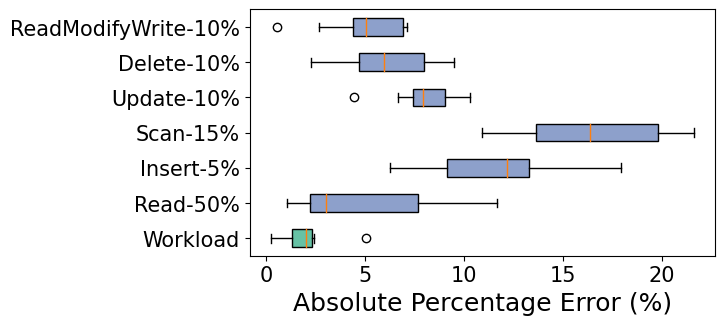

In [57]:
labs = ["Workload"]
labs += [osq_dict['name'] for osq_dict in osq_datas]
print(labs)
# 50,5,15,10,10,10 for read, insert, scan, update, delete, and read&modify
perc_dict = {
    'ReadRecord': 'Read-50%',
    'InsertRecord': 'Insert-5%',
    'ScanRecord': 'Scan-15%',
    'UpdateRecord': 'Update-10%',
    'DeleteRecord': 'Delete-10%',
    'ReadModifyWriteRecord': 'ReadModifyWrite-10%'
}
# perc_dict = {
#     'ReadRecord': 'ReadRecord-\n50%',
#     'InsertRecord': 'InsertRecord-\n5%',
#     'ScanRecord': 'ScanRecord-\n15%',
#     'UpdateRecord': 'UpdateRecord-\n10%',
#     'DeleteRecord': 'DeleteRecord-\n10%',
#     'ReadModifyWriteRecord': 'ReadModify\nWriteRecord-10%'
# }
for k in K_RANGE:
    for p in ALL_PAIRS:
        if p not in result_dict[k]["Workload"]:
            continue
        x_labs = []
        apes = []
        for l in labs:
            r = l.split('-')

            curr_df = result_dict[k][l][p][1][0]
            y_true = curr_df['Y_TRUE_large'].to_numpy()
            y_pred = curr_df['Y_PRED_large'].to_numpy()
            apes.append(100*np.abs(y_true - y_pred)/y_true)
            print(l, np.mean(apes[-1]), np.median(apes[-1]), np.mean(apes[-1]), np.max(apes[-1]), np.min(apes[-1]))

            if len(r) > 1:
                x_labs.append(perc_dict[r[1]])
            else:
                x_labs.append(r[0])
        # fig = plt.figure(figsize =(9.6, 6))
        fig = plt.figure(figsize =(6, 3.2))
        bplot = plt.boxplot(apes, vert=False, labels=x_labs, patch_artist=True)#, whis=(0, 100))
        # plt.boxplot(mapes, vert=False, tick_labels=x_labs, patch_artist=True)
        # fill with colors
        for i, patch in enumerate(bplot['boxes']):
            if i == 0:
                color = '#66c2a5'
            else:
                color = '#8da0cb'
            bplot['boxes'][i].set_facecolor(color)
        plt.xlabel('Absolute Percentage Error (%)')
        plt.savefig(f"figs/ycsb_box{p[0]}-{p[1]}_{k}.png", bbox_inches="tight")
        plt.show()

In [43]:
for temp in apes:
    print(temp)
    print(np.mean(temp))

[5.06480334 0.22577149 1.29426682 1.8497138  2.1777272  2.35286388
 0.93386577 1.37348696 2.26327493 2.39288889]
1.9928663083302833
[ 2.25401223  1.05117949  3.07081323  8.54087796 11.65054817  2.96979986
  6.6740504   2.20312865  1.09433492  7.99708872]
4.750583362635156
[13.39881138 11.74868284 13.01916614  8.57459997  8.60065041 17.96695994
 12.64505891  6.27549591 13.40027593 10.82478828]
11.64544897104389
[21.62106655 12.57856979 17.46064626 15.29788606 21.08858374 13.92736607
 19.33379762 13.56493407 10.89180946 19.98250355]
16.574716317471374
[ 9.69670352  8.42276079  7.80856637  7.62501631  7.37923383  6.68029627
  8.00854961  9.27433869  4.41910796 10.2886971 ]
7.9603270452429316
[4.62938147 7.85274563 2.26985083 4.79846104 8.63276435 9.50153996
 8.04036495 4.8977548  4.46822603 7.0502663 ]
6.214135534768031
[0.52370645 4.34088764 5.21958575 6.93017679 6.91382844 7.13643893
 4.87114725 6.99013523 2.67666212 4.55976575]
5.0162334355557885


In [44]:
def plot_prediction(dfs, labs, k):
    # plot all trends 
    colors = ['#1b9e77','#7570b3','#d95f02','#e7298a']
    # fig, ax = plt.subplots(figsize=(6,2))
    # ax = lin_axs[idx]
    pred_color = colors[0]
    
    true_colors = sns.color_palette("flare", len(labs))
    pred_colors = sns.color_palette("crest", len(labs))
    
    all_true_tracker = {}
        
    for df, lab, run_color in zip(dfs, labs, true_colors):
        expr_label_add = False
        for _, row in df.iterrows():
            curr_x = [row[f'{X_label}{suffix}'] for suffix in suffix_labels]
            true_y = [row[f'{y_true_label}{suffix}'] for suffix in suffix_labels]

            for x, y in zip(np.array(curr_x).flatten(), true_y):
                if x not in all_true_tracker:
                    all_true_tracker[x] = []
                all_true_tracker[x].append(y)

            if not expr_label_add:
                expr = ax.plot(curr_x, true_y, '-', color=run_color, alpha=0.5, linewidth=0.5, label=f'True')
                expr_label_add = True
            else:
                ax.plot(curr_x, true_y, '-', color=run_color, alpha=0.5, linewidth=0.5)
        
    for df, lab, run_color in zip(dfs, labs, pred_colors):
        pred_label_add = False
        for _, row in df.iterrows():
            curr_x = [row[f'{X_label}{suffix}'] for suffix in suffix_labels]
            pred_y = [row[f'{y_true_label}{suffix_labels[0]}'], row[f'{y_pred_label}{suffix_labels[1]}']]

            if not pred_label_add:
                pred_label_add = True
                pred_l = ax.plot(curr_x, pred_y, '-o', color=pred_color, linewidth=0.5, label=f'Predict')
            else:
                ax.plot(curr_x, pred_y, '-o', color=pred_color, linewidth=0.5)
    
    ax.axis('tight')
    ax.set_xlabel('')#'Num CPUs')
    ax.set_ylabel('')#'Latency')
    max_true_y = np.max([ np.max(
        df['Y_PRED_large'].to_list() + df['Y_TRUE_small'].to_list() + df['Y_TRUE_large'].to_list()
    ) for df in dfs])

    ax.set_ylim(ymin=0, ymax=1.1*max_true_y)
    ax.title.set_text('-'.join(labs))
    # ax.set_xticks([4, 16]) # TODO remove hard code

    ax.legend(loc='best')

pred_twitter_2-3_3


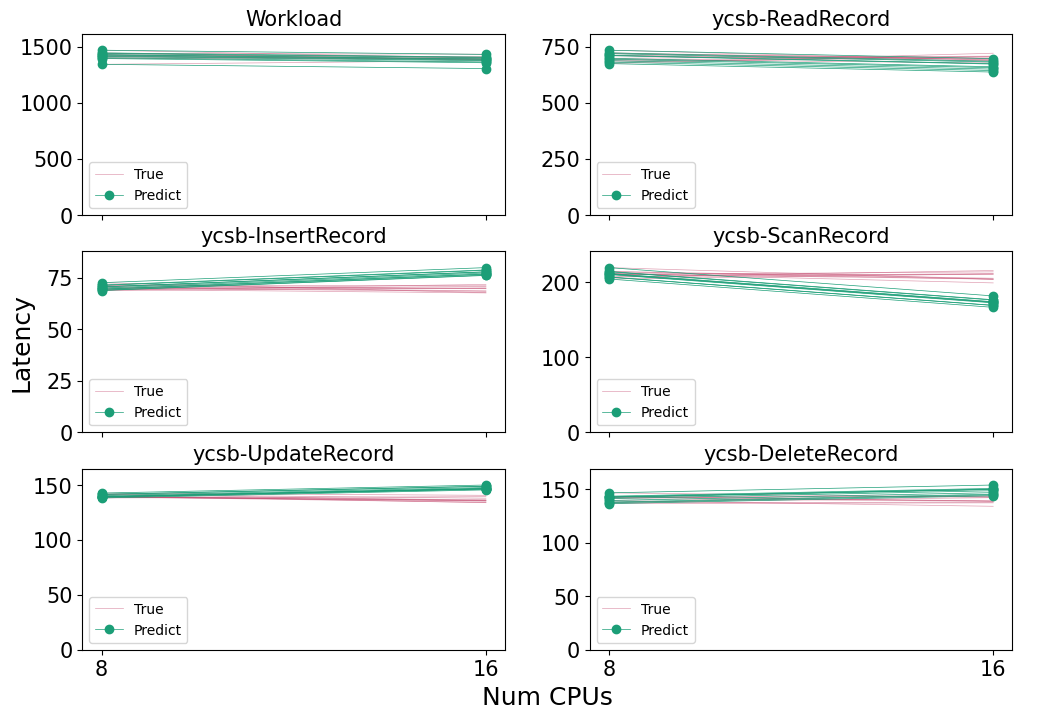

In [45]:
labs = ["Workload"]
labs += [osq_dict['name'] for osq_dict in osq_datas]

for k in K_RANGE:
    for p in [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]:
        if p not in result_dict[k]["Workload"]:
            continue
        fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(12, 8))

        for l, ax in zip(labs, axs.reshape(-1)):
            dfs = result_dict[k][l][p][1]
            plot_prediction(dfs, [l], k)
        plt.xticks([ALL_CPUS[p[0]], ALL_CPUS[p[1]]]) # TODO remove hard code

        fig.add_subplot(111, frameon=False)        
        plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
        plt.xlabel('Num CPUs')
        plt.ylabel('Latency')

        p_substr = f'{p[0]}-{p[1]}'
        print(f'pred_twitter_{p_substr}_{k}')
        plt.savefig(f"figs/pred_twitter_{p_substr}_{k}.png", bbox_inches="tight")
        plt.show()
        
#         # plot workload 
#         dfs = result_dict[k]['Workload'][p][1]
#         assert(len(dfs) == 1)
#         plot_prediction(dfs, ['Workload'], k, True)
        
#         q_dfs = []
#         for l in labs:
#             dfs = result_dict[k][l][p][1]
#             assert(len(dfs) == 1)
#             plot_prediction(dfs, [l], k, True)
#         # plot_prediction(q_dfs, labs, k, True)